# Homotopic optimal control of inverted pendulum

## Dynamics

In [ ]:
from sympy import *
init_printing()

In [ ]:
# state variables
x, v, theta, omega = symbols("x v \\theta, \\omega", real=True)
s = Matrix([x, v, theta, omega])
s.T

In [ ]:
# control parameter
u = symbols('u', real=True, nonzero=True)

# state equations of motion
ds = Matrix([v, u, omega, sin(theta) - u*cos(theta)])
ds

In [ ]:
# homotopy parameters
alpha, beta = symbols('\\alpha \\beta', real=True, nonegative=True)

# homotopy between effort and time
L = beta + (1-beta)*abs(u)

# homotopy between energy and effort/time
L = alpha*L + (1-alpha)*u**2
L

In [ ]:
# costate variables
l = Matrix(symbols(['\\lambda_{' + str(var) + '}' for var in s]), real=True, nonzero=True)
l.T

In [ ]:
# Hamiltonian
H = l.dot(ds) + L
H

In [ ]:
# costate equations of motion
dl = -H.diff(s)
dl

In [ ]:
# optimal control; note that alpha dissappears
# because effort and time optimality are equivalent in this case
us = solve(H.diff(u), u)[0]
us

In [ ]:
# effort/time optimal control (bang-bang)
us.subs(alpha, 1)

## Base trajectory
We first solve for a base trajectory, which will subsequently be used to iniate the forthcoming homotopy sequence approach to reaching the difficultly found bang-bang optimal control.

In [1]:
import sys, numpy as np, matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sys.path.append('../src/')
from pendulum import Pendulum
%matplotlib inline

In [2]:
# instantiate problem
seg = Pendulum()

# solve arguments
s0 = [0,0,np.pi,0]
alpha = 0
Tlb = 5
Tub = 15
lb = 1

In [3]:
# solve
zg = None
zg = [10.21795266,  0.19885557,  0.77306339,  0.99997456,  0.83067696]
#zg = [6.12032571, 0.03676911, 0.90012948, 1.40507211, 0.39248787]
while True:
    z, f, feas = seg.solve(s0, alpha, Tlb, Tub, lb, z=zg)
    if feas:
        break
z

array([10.21795266,  0.19885557,  0.77306339,  0.99997456,  0.83067696])

In [4]:
# simulate the solution's resultant trajectory
tl, sl, ul = seg.propagate(z[0], s0, z[1:], alpha, atol=1e-12, rtol=1e-12, u=True)

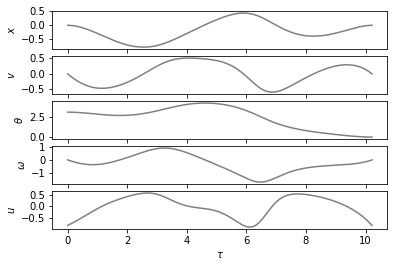

In [5]:
# plot states and control
fig, ax = seg.plot_states(tl, sl, ul)

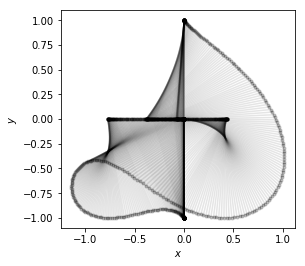

In [6]:
# plot geometric trajectory
fig, ax = seg.plot_traj(tl, sl)

## Policy homotopy

```python
zo = None
a = 0
while a < 1:
    z = solve(zo, a)
    if succesfull(z):
        zo = z
        a = increase(a)
    else:
        a = decrease(a)
```

## Forward homotopy $\alpha: 0 \rightarrow 1$
This brings us to a bang-bang policy with an appropriate magnitude, which is realisable from the original quadratic policy.

In [7]:
#sols = seg.homotopy(s0, 0, Tlb, Tub, 10, z, 1, step=0.001)
sols = np.load("ph.npy")

In [8]:
#np.save('ph.npy', np.flip(sols, axis=0))

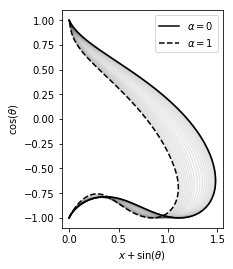

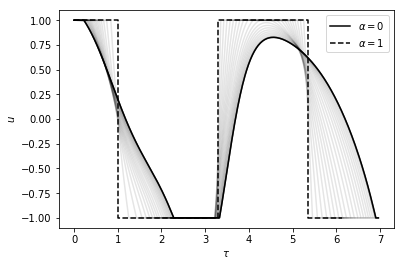

In [9]:
# plot the forward homotopy 
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
for i in range(len(sols)):
    z = sols[i][0]
    a = sols[i][1]
    seg.alpha = a
    tl, sl, ul = seg.propagate(z[0], s0, z[1:], a, u=True)
    x = sl[:,0] + np.sin(sl[:,2])
    y = np.cos(sl[:,2])
    if a == 0:
        ax.plot(x, y, "k-", alpha=1, label=r"$\alpha=0$")
        ax1.plot(tl, ul, "k-", alpha=1, label=r"$\alpha=0$")
    elif a == 1:
        ax.plot(x, y, "k--", alpha=1, label=r"$\alpha=1$")
        ax1.plot(tl, ul, "k--", alpha=1, label=r"$\alpha=1$")
    else:
        ax.plot(x, y, "k-", alpha=0.1)
        ax1.plot(tl, ul, "k-", alpha=0.1)
ax.set_aspect('equal')
ax.legend()
ax1.legend()
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()
fig.savefig("phs.pdf", bbox_inches='tight')
fig1.savefig("phu.pdf", bbox_inches='tight')

## Random walks

```python
T = []
so = snom
zo = znom
while len(T) < N:
    s = perturb(so, ds)
    z = solve(s, zo)
    if succesfull(z):
        so = s
        zo = z
        T.append((so, zo))
        ds = increase(ds)
    else:
        ds = decrease(ds)
        
```

In [ ]:
sols[0]

In [10]:
# arguments
so = s0
zo = zg
zo = sols[0][0]
alpha = 0
n = 1
Tlb = 0
Tub = 15
lb = 5
nw = 8

# random walks
T = seg.random_walk_par(so, zo, alpha, n, Tlb, Tub, lb, nw, dsm=0.02, verbose=True)
#T = np.load('pqdb.npy')

Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02
Success 1. Step sice now 0.02


In [ ]:
#np.save('pqdb.npy', T)

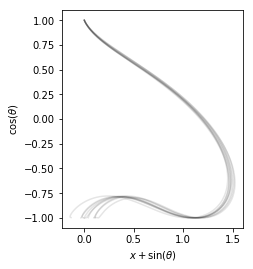

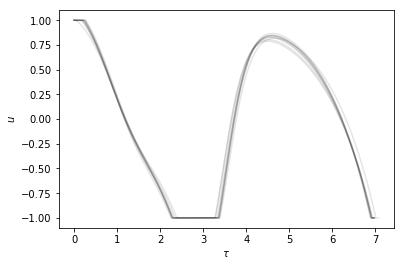

In [11]:
# plot the random walks
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)

# for each random walk
first = False
for t in T:
    
    # initial state
    s0 = t[0]
    
    # decision vector
    z = t[1]
    
    # simulate trajectory
    tl, sll, ul = seg.propagate(z[0], s0, z[1:], alpha, u=True)
    
    # endpoints
    x = sll[:,0] + np.sin(sll[:,2])
    y = np.cos(sll[:,2])
    
    # plot
    if first:
        ax.plot(x, y, "k-", alpha=1, label="Nominal")
        ax1.plot(tl, ul, "k-", alpha=1, label="Nominal")
        first = False
    else:
        ax.plot(x, y, "k-", alpha=0.1)
        ax1.plot(tl, ul, "k-", alpha=0.1)
ax.set_aspect('equal')
#ax.legend()
#ax1.legend()
ax.set_xlabel(r'$f$')
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()
#fig.savefig('pqdbs.pdf', bbox_inches='tight')
#fig1.savefig('pqdbu.pdf', bbox_inches='tight')

## Database homotopy

In [12]:
res = seg.homotopy_db(T, 0, 0, 15, 5, 1, step=0.01)
#res = np.load('pqhdb.npy')

z=[ 6.95087686  0.28681837  0.17282741 -1.06199158 -2.44818139]
a=0.0
z=[ 6.96362291  0.34577269  0.33113881 -1.11776598 -2.60515498]
a=0.0
z=[ 6.96037805  0.30109599  0.20825235 -1.07882774 -2.4866364 ]
a=0.0
z=[ 6.97231416  0.38313855  0.4621362  -1.17247963 -2.68527247]
a=0.0
z=[ 6.96209278  0.33095384  0.2943599  -1.11307475 -2.53239128]
a=0.0
z=[ 6.98219016  0.34496908  0.3145202  -1.13898251 -2.50132824]
a=0.0
z=[ 6.97803304  0.35465916  0.35955107 -1.15030111 -2.54861862]
a=0.0
z=[ 6.97067964  0.32815059  0.28045422 -1.06478973 -2.57667789]
a=0.0
z=[ 6.94638626  0.28392165  0.16691444 -1.06002387 -2.42464311]
a=0.01
z=[ 6.95885594  0.34230301  0.32304744 -1.11662597 -2.58104346]
a=0.01
z=[ 6.95576457  0.29806765  0.20185596 -1.07705784 -2.4629206 ]
a=0.01
z=[ 6.97771703  0.34149898  0.30683977 -1.1370414  -2.47772898]
a=0.01
z=[ 6.96720809  0.37938425  0.45270124 -1.17169264 -2.66087696]
a=0.01
z=[ 6.95744856  0.32763587  0.28691207 -1.11142639 -2.50852524]
a=0.01
z=[ 6.97337318

a=0.13999999999999999
z=[ 6.91865054  0.31197956  0.26268798 -1.1256433  -2.26125411]
a=0.11999999999999998
z=[ 6.89792666  0.28746174  0.19854683 -1.08701956 -2.22121355]
a=0.12999999999999998
z=[ 6.90111898  0.33388261  0.3396582  -1.1583519  -2.3674239 ]
a=0.12999999999999998
z=[ 6.9062478   0.28471568  0.18416468 -1.04707855 -2.26393749]
a=0.12999999999999998
z=[ 6.87847652  0.24294678  0.08553    -1.02684058 -2.09403862]
a=0.15z=[ 6.91520142  0.29597519  0.20809291 -1.10627112 -2.16992523]
a=0.13999999999999999

z=[ 6.89757188  0.30027502  0.22673975 -1.09855457 -2.29070641]
a=0.12999999999999998
z=[ 6.88594255  0.25521648  0.11363305 -1.04655401 -2.12973997]
a=0.15
z=[ 6.89260464  0.28408204  0.19126238 -1.08460412 -2.19719288]
a=0.13999999999999999
z=[ 6.91337233  0.30839001  0.25471458 -1.12313363 -2.23722354]
a=0.12999999999999998
z=[ 6.89515543  0.33005007  0.33024432 -1.15692552 -2.3429117 ]
a=0.13999999999999999
z=[ 6.87320292  0.23998754  0.07980926 -1.02407353 -2.07034566

a=0.26000000000000006
z=[ 6.8177395   0.28349417  0.21811956 -1.13421231 -2.04765907]
a=0.26000000000000006
z=[ 6.80511149  0.20410941  0.01283689 -0.9851584  -1.78500883]
a=0.2800000000000001
z=[ 6.84914374  0.25320168  0.1195089  -1.06707305 -1.88377112]
a=0.26000000000000006
z=[ 6.83831573  0.24385443  0.0978533  -1.02048008 -1.97283391]
a=0.25000000000000006
z=[ 6.82400549  0.24310774  0.10544929 -1.04960502 -1.90775543]
a=0.26000000000000006
z=[ 6.84489193  0.26487158  0.16010151 -1.08769982 -1.94783158]
a=0.25000000000000006
z=[ 6.81695594  0.21773709  0.04069531 -1.01015948 -1.84213817]
a=0.2700000000000001
z=[ 6.82729355  0.25743071  0.13224129 -1.07136922 -1.99826807]
a=0.25000000000000006
z=[ 6.83225974  0.24041398  0.0908416  -1.01767436 -1.94844191]
a=0.26000000000000006
z=[ 6.81070699  0.2795632   0.20882417 -1.13189069 -2.02297274]
a=0.2700000000000001
z=[ 6.84321425  0.24960158  0.11227739 -1.06325443 -1.85982066]
a=0.2700000000000001
z=[ 6.81788581  0.23965755  0.098480

a=0.36000000000000015
z=[ 6.77248692  0.22418261  0.07601859 -1.04454889 -1.6805179 ]
a=0.36000000000000015
z=[ 6.77916796  0.21325613  0.04115318 -1.02044946 -1.61941459]
a=0.37000000000000016
z=[ 6.75215495  0.2048196   0.03028933 -1.0058319  -1.64018792]
a=0.37000000000000016
z=[ 6.74550374  0.21362228  0.04061121 -1.0324937  -1.70318832]
a=0.37000000000000016
z=[ 6.76533351  0.22044109  0.06852063 -1.04006782 -1.65611062]
a=0.37000000000000016
z=[ 6.70582544  0.22750629  0.08604505 -1.10045114 -1.70213887]
a=0.4000000000000002
z=[ 6.75962132  0.20213805  0.01489522 -0.98191891 -1.67895164]
a=0.37000000000000016
z=[ 6.71939333  0.16442266 -0.05493901 -0.92834212 -1.47342985]
a=0.4100000000000002
z=[ 6.74447427  0.18269798 -0.02268969 -0.9655934  -1.57644865]
a=0.38000000000000017
z=[ 6.77227739  0.20958681  0.03421588 -1.01559712 -1.59526736]
a=0.38000000000000017
z=[ 6.74511235  0.20130191  0.02366871 -1.00120208 -1.61574219]
a=0.38000000000000017
z=[ 6.73804676  0.20992243  0.0331

a=0.48000000000000026
z=[ 6.66897255  0.15024762 -0.07585365 -0.91258128 -1.33282529]
a=0.48000000000000026
z=[ 6.63904381  0.1682079  -0.05544292 -0.9938891  -1.40784174]
a=0.49000000000000027
z=[ 6.66348282  0.15927986 -0.06559844 -0.93220687 -1.38238031]
a=0.49000000000000027
z=[ 6.63391145  0.13013883 -0.10639625 -0.86429234 -1.20736409]
a=0.5200000000000002
z=[ 6.66075102  0.17447353 -0.0271457  -0.99222957 -1.36391583]
a=0.49000000000000027
z=[ 6.60387477  0.18299695 -0.02475055 -1.07722457 -1.43481119]
a=0.5100000000000002
z=[ 6.65966418  0.16212671 -0.04704165 -0.94335044 -1.34553725]
a=0.49000000000000027
z=[ 6.66079956  0.14697042 -0.08087972 -0.90651388 -1.30834204]
a=0.49000000000000027
z=[ 6.68148462  0.16834987 -0.0463065  -0.96601118 -1.32975652]
a=0.49000000000000027
z=[ 6.65289651  0.15555593 -0.07352285 -0.92979846 -1.35791604]
a=0.5000000000000002
z=[ 6.62540856  0.12699092 -0.11070702 -0.85755483 -1.18305013]
a=0.5300000000000002
z=[ 6.64978339  0.15845319 -0.054314

a=0.5900000000000003
z=[ 6.53592943  0.11497075 -0.15977859 -0.89647275 -1.09022199]
a=0.6100000000000003
z=[ 6.49871766  0.09064086 -0.16992097 -0.79902648 -0.91603615]
a=0.6400000000000003
z=[ 6.48716643  0.13452305 -0.15096288 -1.04961301 -1.14873359]
a=0.6300000000000003
z=[ 6.5309786   0.10600207 -0.15220031 -0.84789546 -1.01542415]
a=0.6100000000000003
z=[ 6.53956757  0.1280766  -0.13045811 -0.94690477 -1.07546825]
a=0.6100000000000003
z=[ 6.52755431  0.11753044 -0.1411415  -0.90081148 -1.05483603]
a=0.6100000000000003
z=[ 6.50956503  0.11884399 -0.16622037 -0.95177544 -1.0926024 ]
a=0.6200000000000003
z=[ 6.52520234  0.11131448 -0.16756248 -0.89286104 -1.06602895]
a=0.6200000000000003
z=[ 6.56971948  0.12626307 -0.13701093 -0.92501094 -1.06723483]
a=0.6000000000000003
z=[ 6.48486637  0.08723962 -0.17641864 -0.79505561 -0.89201926]
a=0.6500000000000004
z=[ 6.47710196  0.13047974 -0.16187946 -1.04743022 -1.12529835]
a=0.6400000000000003
z=[ 6.51836294  0.10252479 -0.15898078 -0.84

a=0.7500000000000004
z=[ 6.39214482  0.06822626 -0.22395565 -0.79460087 -0.75150112]
a=0.7200000000000004
z=[ 6.40845074  0.08150906 -0.238722   -0.89621596 -0.79124466]
a=0.7300000000000004
z=[ 6.37944162  0.07306739 -0.27587355 -0.91160991 -0.80778175]
a=0.7400000000000004
z=[ 6.44077614  0.08042255 -0.23724571 -0.86957855 -0.78316154]
a=0.7200000000000004
z=[ 6.38911159  0.07334918 -0.23593384 -0.84662709 -0.76826244]
a=0.7300000000000004
z=[ 6.38919694  0.06728531 -0.26484392 -0.84853362 -0.77882701]
a=0.7400000000000004
z=[ 6.33453697  0.0506619  -0.24244282 -0.73645049 -0.63011348]
a=0.7600000000000005
z=[ 6.37892574  0.06480047 -0.23058835 -0.78936478 -0.7277488 ]
a=0.7300000000000004
z=[ 6.35555272  0.08209828 -0.29951599 -1.02555009 -0.85214547]
a=0.7600000000000005
z=[ 6.39701428  0.07760039 -0.24826629 -0.89210948 -0.76788294]
a=0.7400000000000004
z=[ 6.36825276  0.0692308  -0.28558911 -0.90849922 -0.78448135]
a=0.7500000000000004
z=[ 6.37690127  0.06964632 -0.24427173 -0.84

a=0.8400000000000005
z=[ 6.22620799  0.02679931 -0.31027506 -0.7346112  -0.47101592]
a=0.8400000000000005
z=[ 6.2568863   0.03945951 -0.4356383  -1.0164618  -0.62547801]
a=0.8700000000000006
z=[ 6.26139752  0.03031977 -0.37282355 -0.84788781 -0.49403221]
a=0.8600000000000005
z=[ 6.24712668  0.02260882 -0.37720498 -0.81103722 -0.50186122]
a=0.8600000000000005
z=[ 6.15615803  0.01034335 -0.32510462 -0.67268995 -0.35256518]
a=0.8800000000000006
z=[ 6.24912475  0.02691035 -0.40089259 -0.87956252 -0.53544116]
a=0.8600000000000005
z=[ 6.24065788  0.02855164 -0.34423598 -0.79736234 -0.49066103]
a=0.8500000000000005
z=[ 6.21215571  0.02330223 -0.31844707 -0.73025429 -0.44823626]
a=0.8500000000000005
z=[ 6.24952994  0.03586622 -0.44796387 -1.01632362 -0.6071061 ]
a=0.8800000000000006
z=[ 6.29070954  0.02962769 -0.36037415 -0.81095444 -0.48101399]
a=0.8500000000000005
z=[ 6.25100452  0.02636565 -0.38419609 -0.84481345 -0.47197236]
a=0.8700000000000006
z=[ 6.23608086  0.01885628 -0.38765638 -0.80

a=0.9500000000000006
z=[ 6.15266068 -0.01661314 -0.49510596 -0.79072892 -0.27547016]
a=0.9700000000000006
z=[ 6.17184131 -0.0087469  -0.51302317 -0.86468947 -0.33837502]
a=0.9600000000000006
z=[ 6.20218149  0.00894906 -0.54559663 -1.01903505 -0.47353472]
a=0.9900000000000003
z=[ 6.08286527 -0.01517388 -0.42265589 -0.69484215 -0.20960278]
a=0.9600000000000006
z=[ 6.13347415 -0.01186707 -0.46219727 -0.76746199 -0.25778724]
a=0.9600000000000006
z=[ 6.14882026 -0.01909677 -0.50332234 -0.78978334 -0.26164583]
a=0.9800000000000006
z=[ 6.17009209 -0.01234202 -0.50545414 -0.82036287 -0.26338172]
a=0.9800000000000006
z=[ 6.16778229 -0.01133382 -0.52183313 -0.86397339 -0.32455779]
a=0.9700000000000006
z=[ 6.18920107 -0.0143716  -0.48604358 -0.76971515 -0.23507991]
a=0.9600000000000006
z=[ 6.0759844  -0.01834086 -0.43242925 -0.69269786 -0.19080042]
a=0.9700000000000006
z=[ 6.16794012 -0.01390967 -0.51081076 -0.8195715  -0.25522219]
a=0.9900000000000003
z=[ 6.14635037 -0.02085419 -0.50919209 -0.78

a=0.6700000000000004
z=[ 6.56097343  0.10478793 -0.110267   -0.77379131 -0.84748295]
a=0.6800000000000004
z=[ 6.54855575  0.10090176 -0.11872614 -0.76892971 -0.82382863]
a=0.6900000000000004
z=[ 6.53599548  0.09701144 -0.12723458 -0.76402933 -0.80019837]
a=0.7000000000000004
z=[ 6.52334598  0.09311947 -0.13573901 -0.75900091 -0.77657947]
a=0.7100000000000004
z=[ 6.51057197  0.08922372 -0.14427589 -0.75389973 -0.75298068]
a=0.7200000000000004
z=[ 6.4976827   0.08532436 -0.1528382  -0.74871073 -0.72940043]
a=0.7300000000000004
z=[ 6.48462972  0.08141813 -0.16148476 -0.74352238 -0.70585308]
a=0.7400000000000004
z=[ 6.47146384  0.07750735 -0.17016739 -0.73825354 -0.68232712]
a=0.7500000000000004
z=[ 6.45814756  0.07358899 -0.1789403  -0.73298364 -0.65883584]
a=0.7600000000000005
z=[ 6.44472615  0.069665   -0.18776352 -0.72764442 -0.63536956]
a=0.7700000000000005
z=[ 6.43118742  0.06573352 -0.19666871 -0.72227872 -0.61193597]
a=0.7800000000000005
z=[ 6.41753321  0.06179329 -0.20567665 -0.71

In [ ]:
#np.save('pqhdb.npy', res)

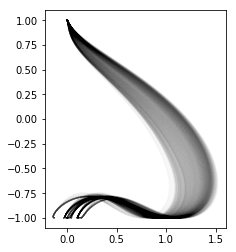

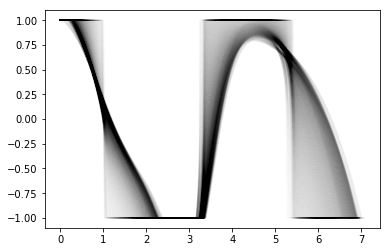

In [13]:
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)

for r in res:
    
    # initial state
    s0 = r[0]
    
    # decision vector
    z = r[1]
    
    # homotopy parameter
    alpha = r[2]
    
    # simulate trajectory
    tl, sll, ul = seg.propagate(z[0], s0, z[1:], alpha, u=True)
    
    # endpoints
    x = sll[:,0] + np.sin(sll[:,2])
    y = np.cos(sll[:,2])
    
    # plot
    if alpha > 1.2:
        ax.plot(x, y, "k--", alpha=1)
        ax1.plot(tl, ul, "k--", alpha=1)
    else:
        ax.plot(x, y, "k-", alpha=0.01)
        ax1.plot(tl, ul, "k-", alpha=0.01)
ax.set_aspect('equal')
    
plt.show()    
#fig1.savefig('phdbu.pdf')

# Training a neural network

In [15]:
from ann import *

In [16]:
# generate the databases
data = seg.gen_db(res, cat=True)
#data = np.load('pqhanndb.npy')

In [ ]:
# save the database
#np.save('pqhanndb.npy', data)

In [17]:
# format the data for the ann
db = Data(data, [0, 1, 2, 3, 4], [5])

In [55]:
# instantiate the neural network
mlp = Pendulum_Controller([5, 100, 100, 1])

In [56]:
mlp.train(db.i, db.o, epo=2000, lr=1e-3, gpu=True, ptst=0.2)

Episode 0; Testing Loss 0.7545225019635504; Training Loss 0.754642069588092
Episode 1; Testing Loss 0.7216798501209971; Training Loss 0.7217608890750462
Episode 2; Testing Loss 0.6925326686063306; Training Loss 0.6925721348145821
Episode 3; Testing Loss 0.6656219688895718; Training Loss 0.6656291182734559
Episode 4; Testing Loss 0.6396786072025469; Training Loss 0.6396515464209384
Episode 5; Testing Loss 0.6147632983696845; Training Loss 0.6146993049322413
Episode 6; Testing Loss 0.5910262946903889; Training Loss 0.5909398077774676
Episode 7; Testing Loss 0.5681332232787678; Training Loss 0.5680229502690872
Episode 8; Testing Loss 0.5462711618522462; Training Loss 0.5461451507376331
Episode 9; Testing Loss 0.5249181426027325; Training Loss 0.5247784977214253
Episode 10; Testing Loss 0.5035582401355015; Training Loss 0.50340366706726
Episode 11; Testing Loss 0.48220899163347675; Training Loss 0.4820352760879945
Episode 12; Testing Loss 0.4609160444760398; Training Loss 0.460722927344413

Episode 103; Testing Loss 0.035955152416816176; Training Loss 0.035638205769964015
Episode 104; Testing Loss 0.035854324618446905; Training Loss 0.03553582994739287
Episode 105; Testing Loss 0.035759327833033254; Training Loss 0.035438446204322564
Episode 106; Testing Loss 0.03566153734888565; Training Loss 0.03533888427983604
Episode 107; Testing Loss 0.03555894592607895; Training Loss 0.035235168158074946
Episode 108; Testing Loss 0.03545253203745774; Training Loss 0.03512851046068051
Episode 109; Testing Loss 0.035347090732010804; Training Loss 0.03502287803347944
Episode 110; Testing Loss 0.03524157908104519; Training Loss 0.03491807176365071
Episode 111; Testing Loss 0.03513076817654465; Training Loss 0.034808751401198476
Episode 112; Testing Loss 0.035016765364427126; Training Loss 0.03469662278083936
Episode 113; Testing Loss 0.03490382311120032; Training Loss 0.034585523360452675
Episode 114; Testing Loss 0.03479204178305722; Training Loss 0.034474841222031476
Episode 115; Test

Episode 203; Testing Loss 0.02476937449620227; Training Loss 0.024418848892394443
Episode 204; Testing Loss 0.02465559550734655; Training Loss 0.024305095427734298
Episode 205; Testing Loss 0.024540459465646994; Training Loss 0.024189829567192525
Episode 206; Testing Loss 0.024423675011329284; Training Loss 0.024073154961620956
Episode 207; Testing Loss 0.02430527165520797; Training Loss 0.02395509214252094
Episode 208; Testing Loss 0.02418533805401389; Training Loss 0.023835521931741748
Episode 209; Testing Loss 0.024063357863392927; Training Loss 0.02371409029635989
Episode 210; Testing Loss 0.02393968180859287; Training Loss 0.023590701579768322
Episode 211; Testing Loss 0.023814420988499972; Training Loss 0.023465680025299678
Episode 212; Testing Loss 0.023687843547566426; Training Loss 0.023339165904384254
Episode 213; Testing Loss 0.023559995757822996; Training Loss 0.023211088649542713
Episode 214; Testing Loss 0.02343080836613366; Training Loss 0.023081773936068885
Episode 215;

Episode 303; Testing Loss 0.01540027926865743; Training Loss 0.015062106705315655
Episode 304; Testing Loss 0.01535192469492448; Training Loss 0.015020475245173553
Episode 305; Testing Loss 0.015312443112997048; Training Loss 0.01497166697155905
Episode 306; Testing Loss 0.015243815189627492; Training Loss 0.01491206655136263
Episode 307; Testing Loss 0.01518887011921124; Training Loss 0.0148530090372577
Episode 308; Testing Loss 0.015141823178182799; Training Loss 0.014804605724149305
Episode 309; Testing Loss 0.015091689484297956; Training Loss 0.014760697305723807
Episode 310; Testing Loss 0.015049741114074347; Training Loss 0.014710942116416758
Episode 311; Testing Loss 0.014986938521198092; Training Loss 0.01465542596406175
Episode 312; Testing Loss 0.014935836430028339; Training Loss 0.01460175823029379
Episode 313; Testing Loss 0.014889131673881386; Training Loss 0.014554316196399616
Episode 314; Testing Loss 0.01483906750642388; Training Loss 0.014509542311379181
Episode 315; T

Episode 403; Testing Loss 0.011563700919639399; Training Loss 0.01125879341863159
Episode 404; Testing Loss 0.011537010324502522; Training Loss 0.01123117808949625
Episode 405; Testing Loss 0.01150795396432575; Training Loss 0.011203756294970729
Episode 406; Testing Loss 0.011482606997092335; Training Loss 0.011176521299384038
Episode 407; Testing Loss 0.011452511312526174; Training Loss 0.011149469674803578
Episode 408; Testing Loss 0.01142875271769655; Training Loss 0.011122908566863066
Episode 409; Testing Loss 0.011397695835724865; Training Loss 0.01109701909272829
Episode 410; Testing Loss 0.011378594443448629; Training Loss 0.01107217173792922
Episode 411; Testing Loss 0.011347525549134947; Training Loss 0.01104934823068902
Episode 412; Testing Loss 0.011339070847858755; Training Loss 0.01102962116204437
Episode 413; Testing Loss 0.011309437893247554; Training Loss 0.011015329029431068
Episode 414; Testing Loss 0.011327447289817083; Training Loss 0.011013194417569143
Episode 415;

Episode 503; Testing Loss 0.0093895587519626; Training Loss 0.009102366626144498
Episode 504; Testing Loss 0.009375630261617718; Training Loss 0.00909777648794591
Episode 505; Testing Loss 0.009382126175033237; Training Loss 0.00909083564666333
Episode 506; Testing Loss 0.009347962278885338; Training Loss 0.00907344043817108
Episode 507; Testing Loss 0.009333640363723321; Training Loss 0.009046642512497505
Episode 508; Testing Loss 0.009299899252572125; Training Loss 0.00902107116020488
Episode 509; Testing Loss 0.00928407601744876; Training Loss 0.009004111505728774
Episode 510; Testing Loss 0.009280553359958792; Training Loss 0.008994597441874915
Episode 511; Testing Loss 0.009261828772533539; Training Loss 0.008985655591741772
Episode 512; Testing Loss 0.009258900614426427; Training Loss 0.008970936828235848
Episode 513; Testing Loss 0.009226914749832118; Training Loss 0.008950545218294272
Episode 514; Testing Loss 0.00921232551605954; Training Loss 0.00892872091535434
Episode 515; 

Episode 603; Testing Loss 0.008032853109703685; Training Loss 0.007773020047498581
Episode 604; Testing Loss 0.008020704637890518; Training Loss 0.007762322980842677
Episode 605; Testing Loss 0.008012429757774015; Training Loss 0.007751895686967092
Episode 606; Testing Loss 0.007999441281644636; Training Loss 0.007741671302443402
Episode 607; Testing Loss 0.00799403760182557; Training Loss 0.0077319288043086794
Episode 608; Testing Loss 0.00797963926511282; Training Loss 0.0077231751781915905
Episode 609; Testing Loss 0.007979791463905745; Training Loss 0.007715835063096228
Episode 610; Testing Loss 0.007964774462736588; Training Loss 0.0077112936749425
Episode 611; Testing Loss 0.007977866306567565; Training Loss 0.007710956533598469
Episode 612; Testing Loss 0.00796750297560748; Training Loss 0.007718306195324828
Episode 613; Testing Loss 0.008008806646184198; Training Loss 0.007736208433321203
Episode 614; Testing Loss 0.008015785997339719; Training Loss 0.007772828222783872
Episode

Episode 702; Testing Loss 0.007183090267025861; Training Loss 0.006927790109573263
Episode 703; Testing Loss 0.0071805044787998035; Training Loss 0.006946480666660516
Episode 704; Testing Loss 0.007238064649047357; Training Loss 0.006976306867328743
Episode 705; Testing Loss 0.007252491959557225; Training Loss 0.007023734516890085
Episode 706; Testing Loss 0.007340941428973008; Training Loss 0.007071506189938134
Episode 707; Testing Loss 0.007341031443716026; Training Loss 0.007116328148619377
Episode 708; Testing Loss 0.007367944915661565; Training Loss 0.007096268678115195
Episode 709; Testing Loss 0.007251489545958487; Training Loss 0.007024515023120849
Episode 710; Testing Loss 0.007165775136097866; Training Loss 0.006906899925941513
Episode 711; Testing Loss 0.007068131544836332; Training Loss 0.006827871517701203
Episode 712; Testing Loss 0.007061709636899371; Training Loss 0.006821892365413568
Episode 713; Testing Loss 0.007125829094017189; Training Loss 0.006869062386614347
Epi

Episode 801; Testing Loss 0.00651405341108548; Training Loss 0.006291334425532278
Episode 802; Testing Loss 0.006488199978748125; Training Loss 0.006250870224442359
Episode 803; Testing Loss 0.006460051496928074; Training Loss 0.006229233038380205
Episode 804; Testing Loss 0.006458253108274526; Training Loss 0.006229675270151931
Episode 805; Testing Loss 0.006481826248586088; Training Loss 0.006242428215942867
Episode 806; Testing Loss 0.006478296044926502; Training Loss 0.006254701666560305
Episode 807; Testing Loss 0.006495521526738296; Training Loss 0.006253966368466674
Episode 808; Testing Loss 0.006463900446729152; Training Loss 0.006241020833232872
Episode 809; Testing Loss 0.006456079507852874; Training Loss 0.006218523876483391
Episode 810; Testing Loss 0.006424404892921486; Training Loss 0.006197646910450358
Episode 811; Testing Loss 0.00641592539450762; Training Loss 0.0061846445246220684
Episode 812; Testing Loss 0.006413812017124978; Training Loss 0.006181139677487365
Episo

Episode 900; Testing Loss 0.00600740849471038; Training Loss 0.005780359628608646
Episode 901; Testing Loss 0.005994457565936912; Training Loss 0.005786396586179536
Episode 902; Testing Loss 0.006019600549325814; Training Loss 0.005790883313818311
Episode 903; Testing Loss 0.006003036649828092; Training Loss 0.005796660230096451
Episode 904; Testing Loss 0.0060281886598486335; Training Loss 0.00579816100149857
Episode 905; Testing Loss 0.006005373545636095; Training Loss 0.0057997031423703774
Episode 906; Testing Loss 0.0060238461415028; Training Loss 0.005793483870443073
Episode 907; Testing Loss 0.005991229663079461; Training Loss 0.005785670339222553
Episode 908; Testing Loss 0.0059971522091095165; Training Loss 0.00576869240974024
Episode 909; Testing Loss 0.005956538944848793; Training Loss 0.005749640685807184
Episode 910; Testing Loss 0.005950295437403832; Training Loss 0.005725580807350961
Episode 911; Testing Loss 0.005911913866186726; Training Loss 0.005701356444504269
Episod

Episode 999; Testing Loss 0.005467157545911828; Training Loss 0.00526325477924346
Episode 1000; Testing Loss 0.005468980483250593; Training Loss 0.0052572395505616105
Episode 1001; Testing Loss 0.005455628296134885; Training Loss 0.00525038284426565
Episode 1002; Testing Loss 0.005454658166117578; Training Loss 0.005243314908358959
Episode 1003; Testing Loss 0.005443981679340663; Training Loss 0.005236650020978301
Episode 1004; Testing Loss 0.005440589341245952; Training Loss 0.005230749862394821
Episode 1005; Testing Loss 0.005433446025262858; Training Loss 0.005225550880562794
Episode 1006; Testing Loss 0.005428142725207177; Training Loss 0.00522088508772412
Episode 1007; Testing Loss 0.005425499929623775; Training Loss 0.005216566545628766
Episode 1008; Testing Loss 0.005419272099879348; Training Loss 0.005212500554860846
Episode 1009; Testing Loss 0.005418777451160774; Training Loss 0.005208550437940401
Episode 1010; Testing Loss 0.005410382226834988; Training Loss 0.00520457129834

Episode 1097; Testing Loss 0.005146532444905072; Training Loss 0.0049640183840827514
Episode 1098; Testing Loss 0.005220132509130509; Training Loss 0.004998544955431635
Episode 1099; Testing Loss 0.005219488924552645; Training Loss 0.0050382161290507
Episode 1100; Testing Loss 0.005272031111954814; Training Loss 0.005045937261245026
Episode 1101; Testing Loss 0.005215883125169598; Training Loss 0.005035331128219356
Episode 1102; Testing Loss 0.005198859208371499; Training Loss 0.004976952270269459
Episode 1103; Testing Loss 0.005091283331952808; Training Loss 0.0049052633984643
Episode 1104; Testing Loss 0.005040731696423731; Training Loss 0.004831370612062793
Episode 1105; Testing Loss 0.004983896506337136; Training Loss 0.004788375824412185
Episode 1106; Testing Loss 0.004979562278589614; Training Loss 0.004783937907238193
Episode 1107; Testing Loss 0.005015923063676371; Training Loss 0.004808390235335289
Episode 1108; Testing Loss 0.005030951457858002; Training Loss 0.00484319081402

Episode 1195; Testing Loss 0.004685295483167185; Training Loss 0.004498551329858088
Episode 1196; Testing Loss 0.0046985180644192135; Training Loss 0.00449611781572647
Episode 1197; Testing Loss 0.004677470916125583; Training Loss 0.004491310767196291
Episode 1198; Testing Loss 0.0046846824931274424; Training Loss 0.004483764650554858
Episode 1199; Testing Loss 0.004662944417988546; Training Loss 0.00447526521994546
Episode 1200; Testing Loss 0.004664867925722032; Training Loss 0.0044661230830990595
Episode 1201; Testing Loss 0.004647893055237611; Training Loss 0.004457704239124146
Episode 1202; Testing Loss 0.0046466377141920435; Training Loss 0.004450823998443476
Episode 1203; Testing Loss 0.004639084205396838; Training Loss 0.0044459147310871175
Episode 1204; Testing Loss 0.004635820779155372; Training Loss 0.004442895535456257
Episode 1205; Testing Loss 0.004636427069977625; Training Loss 0.004441216433678135
Episode 1206; Testing Loss 0.00463050555749992; Training Loss 0.004440405

Episode 1293; Testing Loss 0.004417566460626217; Training Loss 0.004238513004574182
Episode 1294; Testing Loss 0.004431601049682186; Training Loss 0.004233055082685962
Episode 1295; Testing Loss 0.004406735610552436; Training Loss 0.004227587064361655
Episode 1296; Testing Loss 0.004418160725646525; Training Loss 0.004221300408622605
Episode 1297; Testing Loss 0.004394931150188544; Training Loss 0.004215107482842368
Episode 1298; Testing Loss 0.004404736897000466; Training Loss 0.004208755989505661
Episode 1299; Testing Loss 0.004383945117652392; Training Loss 0.004202899154747513
Episode 1300; Testing Loss 0.004391837300318865; Training Loss 0.004197185455385784
Episode 1301; Testing Loss 0.0043739156853759; Training Loss 0.0041921777495738215
Episode 1302; Testing Loss 0.004381312579809287; Training Loss 0.004187686559278178
Episode 1303; Testing Loss 0.004366094689266466; Training Loss 0.004183788330408882
Episode 1304; Testing Loss 0.004373156226817006; Training Loss 0.004180360937

Episode 1391; Testing Loss 0.004186806305387696; Training Loss 0.004019781870516951
Episode 1392; Testing Loss 0.004160525997608422; Training Loss 0.00397578819863606
Episode 1393; Testing Loss 0.004131618013319917; Training Loss 0.003954951355129987
Episode 1394; Testing Loss 0.0041335475942501695; Training Loss 0.003959225452005815
Episode 1395; Testing Loss 0.004166577473355376; Training Loss 0.003978717946426869
Episode 1396; Testing Loss 0.004167753364368269; Training Loss 0.003999769207892025
Episode 1397; Testing Loss 0.0042006693242841245; Training Loss 0.004008723240356903
Episode 1398; Testing Loss 0.004170823946313684; Training Loss 0.004004027471332418
Episode 1399; Testing Loss 0.004174549522163245; Training Loss 0.0039851241875354425
Episode 1400; Testing Loss 0.004133487786814329; Training Loss 0.003962910138478387
Episode 1401; Testing Loss 0.004126565305388255; Training Loss 0.003943895832136139
Episode 1402; Testing Loss 0.004111532429364206; Training Loss 0.003934116

Episode 1489; Testing Loss 0.003942794684026065; Training Loss 0.0037771083959721847
Episode 1490; Testing Loss 0.003966532979411227; Training Loss 0.0037861894953893954
Episode 1491; Testing Loss 0.003959681365117379; Training Loss 0.003796849471734351
Episode 1492; Testing Loss 0.003991090491941154; Training Loss 0.0038068457943198557
Episode 1493; Testing Loss 0.003977107334037891; Training Loss 0.003816628565450459
Episode 1494; Testing Loss 0.004007924309453115; Training Loss 0.0038222429411788623
Episode 1495; Testing Loss 0.0039855985636037435; Training Loss 0.0038269240874587037
Episode 1496; Testing Loss 0.00401104467712905; Training Loss 0.003824904246374879
Episode 1497; Testing Loss 0.003980383701080759; Training Loss 0.003821220362891614
Episode 1498; Testing Loss 0.003997405149008651; Training Loss 0.0038119400615485447
Episode 1499; Testing Loss 0.003961608707898761; Training Loss 0.0038007017908712926
Episode 1500; Testing Loss 0.00396728181560652; Training Loss 0.00378

Episode 1586; Testing Loss 0.00388432936969542; Training Loss 0.0036993870052062063
Episode 1587; Testing Loss 0.003850710060524012; Training Loss 0.003696075197307812
Episode 1588; Testing Loss 0.0038687832771315367; Training Loss 0.0036850107221034567
Episode 1589; Testing Loss 0.003827911416297672; Training Loss 0.0036718303572997896
Episode 1590; Testing Loss 0.003833352366604737; Training Loss 0.00365330301127871
Episode 1591; Testing Loss 0.0037940567793850865; Training Loss 0.003635362916730592
Episode 1592; Testing Loss 0.0037940266145554276; Training Loss 0.003618425328936979
Episode 1593; Testing Loss 0.0037680496042146704; Training Loss 0.00360528479188007
Episode 1594; Testing Loss 0.003767436893241681; Training Loss 0.0035962132480490796
Episode 1595; Testing Loss 0.00375812553068881; Training Loss 0.0035911148366911316
Episode 1596; Testing Loss 0.0037566690231424682; Training Loss 0.003589231925593124
Episode 1597; Testing Loss 0.0037600999306216898; Training Loss 0.0035

Episode 1683; Testing Loss 0.0037241570752311257; Training Loss 0.00357474507769946
Episode 1684; Testing Loss 0.0037318071992516757; Training Loss 0.0035537534256184847
Episode 1685; Testing Loss 0.00368368906329965; Training Loss 0.003532064859963344
Episode 1686; Testing Loss 0.003680871558186707; Training Loss 0.003508039300931644
Episode 1687; Testing Loss 0.003643448108203619; Training Loss 0.0034878068510964207
Episode 1688; Testing Loss 0.0036393673439517296; Training Loss 0.003472186873940282
Episode 1689; Testing Loss 0.0036235102039524052; Training Loss 0.003463039084521975
Episode 1690; Testing Loss 0.003622182024905998; Training Loss 0.003459813198021001
Episode 1691; Testing Loss 0.0036260872203472193; Training Loss 0.0034610747211048423
Episode 1692; Testing Loss 0.003623402663114366; Training Loss 0.0034654273119217524
Episode 1693; Testing Loss 0.003639515941379708; Training Loss 0.0034716689842772537
Episode 1694; Testing Loss 0.0036336646142129054; Training Loss 0.00

Episode 1780; Testing Loss 0.0037069431058879884; Training Loss 0.0035261117564047272
Episode 1781; Testing Loss 0.0036888592041643973; Training Loss 0.0035473088173709833
Episode 1782; Testing Loss 0.003728709590536654; Training Loss 0.0035460286856686717
Episode 1783; Testing Loss 0.003680905305029255; Training Loss 0.0035389863545863902
Episode 1784; Testing Loss 0.0036848187812307007; Training Loss 0.003505080017430718
Episode 1785; Testing Loss 0.0036114387510882686; Training Loss 0.0034668188302169494
Episode 1786; Testing Loss 0.003591036446472376; Training Loss 0.003418681136081331
Episode 1787; Testing Loss 0.003529947829449128; Training Loss 0.0033797265245707818
Episode 1788; Testing Loss 0.003516032944504912; Training Loss 0.0033531632811568592
Episode 1789; Testing Loss 0.0034997283451051807; Training Loss 0.00334224094370877
Episode 1790; Testing Loss 0.0034999997704558126; Training Loss 0.003344808240622104
Episode 1791; Testing Loss 0.003520434363112021; Training Loss 0

Episode 1877; Testing Loss 0.0034187312790407024; Training Loss 0.0032691008762511355
Episode 1878; Testing Loss 0.003423504431476807; Training Loss 0.003261899830802616
Episode 1879; Testing Loss 0.003407573743626336; Training Loss 0.0032557421145494297
Episode 1880; Testing Loss 0.003409449770569003; Training Loss 0.003250821796240144
Episode 1881; Testing Loss 0.0034012065228656964; Training Loss 0.003247301541961992
Episode 1882; Testing Loss 0.003401739583321798; Training Loss 0.0032450245405556415
Episode 1883; Testing Loss 0.0033993662640965094; Training Loss 0.003243686042468413
Episode 1884; Testing Loss 0.0033977412346032324; Training Loss 0.003243059364691881
Episode 1885; Testing Loss 0.003400178707664523; Training Loss 0.003242935798935658
Episode 1886; Testing Loss 0.003396607280392069; Training Loss 0.0032431822369140325
Episode 1887; Testing Loss 0.0034029012482187236; Training Loss 0.003243890733975266
Episode 1888; Testing Loss 0.00339695380097418; Training Loss 0.003

Episode 1974; Testing Loss 0.0033507821565447672; Training Loss 0.003188808808964918
Episode 1975; Testing Loss 0.003332509442726229; Training Loss 0.0031857823675191625
Episode 1976; Testing Loss 0.0033441943793936705; Training Loss 0.0031821459758135965
Episode 1977; Testing Loss 0.0033269095207849753; Training Loss 0.003179517543035986
Episode 1978; Testing Loss 0.0033369662502385875; Training Loss 0.003176270388997288
Episode 1979; Testing Loss 0.003321618355447732; Training Loss 0.0031737595634278963
Episode 1980; Testing Loss 0.0033312269825740335; Training Loss 0.0031708740912705143
Episode 1981; Testing Loss 0.003317264378093596; Training Loss 0.0031689211327353872
Episode 1982; Testing Loss 0.0033261230000804914; Training Loss 0.0031664446428476393
Episode 1983; Testing Loss 0.0033129041156185848; Training Loss 0.003164687474073408
Episode 1984; Testing Loss 0.003321654914802708; Training Loss 0.003162763117625666
Episode 1985; Testing Loss 0.003310266504071575; Training Loss 

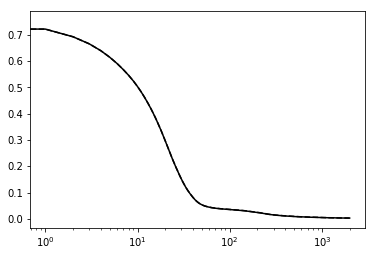

In [57]:
fig, ax = plt.subplots(1)
ax.plot(mlp.ltrn, "k-")
ax.plot(mlp.ltst, "k--")
ax.set_xscale('log')
#ax.set_yscale('log')
plt.show()

In [58]:
mlp.cpu()

Pendulum_Controller(
  (0): Linear(in_features=5, out_features=100, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=100, out_features=1, bias=True)
  (5): Tanh()
)

## Simulating the neural network controller

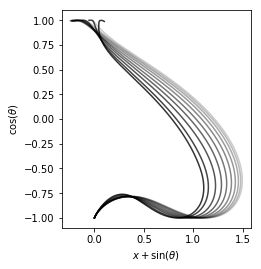

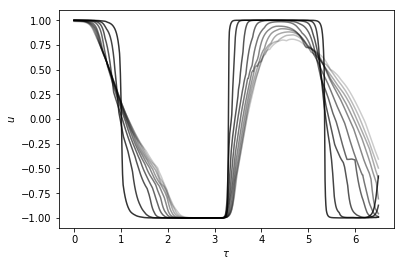

In [59]:
fig, ax = plt.subplots(1)
fig1, ax1 = plt.subplots(1)
s0 = np.array([0, 0, np.pi, 0])
n = 10
for alpha, alphac in zip(np.linspace(0, 1, n), np.linspace(0.2, 0.8, n)):
    T = 6.5
    tl, sl, ul = seg.propagate_controller(T, s0, mlp.predict, alpha, atol=1e-13, rtol=1e-13)
    x = sl[:,0] + np.sin(sl[:,2])
    y = np.cos(sl[:,2])
    ax.plot(x, y, "k-", alpha=alphac)
    ax1.plot(tl, ul, "k-", alpha=alphac)
ax.set_aspect('equal')
ax.set_xlabel(r'$f$')
ax.set_xlabel(r"$x + \sin\left(\theta\right)$")
ax.set_ylabel(r"$\cos\left(\theta\right)$")
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$u$')
plt.show()

## Neural network accuracy

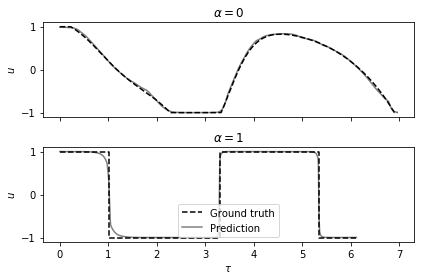

In [60]:
n = 2

fig, ax = plt.subplots(n, sharex=True)
s = np.array([0, 0, np.pi, 0])
il = np.linspace(0, len(sols)-1, n, dtype=int)
for i, j in zip(il, range(n)):
    
    # simulate
    z = sols[i][0]
    alpha = sols[i][1]
    tl, sl, ul = seg.propagate(z[0], s, z[1:], alpha, u=True)
    tst = torch.tensor(np.hstack((sl[:, :seg.sdim], np.full((len(sl), 1), alpha))))
    tst = mlp(tst).detach().numpy().flatten()
    ax[j].plot(tl, ul, "k--")
    ax[j].plot(tl, tst, "k-", alpha=0.5)
    ax[j].set_title(r'$\alpha = {:.0f}$'.format(alpha))
    ax[j].set_ylabel(r'$u$')
    
ax[-1].set_xlabel(r'$\tau$')
ax[-1].legend(['Ground truth', 'Prediction'])
    
plt.tight_layout()
plt.show()
fig.savefig('punn.pdf', bbox_inches='tight')